<a href="https://colab.research.google.com/github/faheem-khaskheli/Generative-Adversarial-Networks/blob/main/CELEB_PGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/'

Mounted at /gdrive
/gdrive/My Drive


# Imports

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [ ]:
from keras.models import Input, Model
from keras.layers import Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, LeakyReLU, Flatten, BatchNormalization, Dense, Reshape,UpSampling2D
from keras.optimizers import Adam

# Variables

In [ ]:
latent_dim = 100

# Dataset

## Load Images, Data Preprocess

In [ ]:
def load_image(path):

#  global IMAGE_SIZE

  img = cv2.imread(path)
#  img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE) )
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = data_preprocessing(img)
  return img

def data_preprocessing(img):
  '''Convert Pixel Values between -1 and 1'''
  img = img - 127.5
  img = img / 127.5

  return img

def inverse_data_preprocessing(img):
  '''Convert Pixel Values between 0 and 255'''
  img = img * 127.5
  img = img + 127.5
  img = img.astype('uint8')
  return img

## Load Images Path

In [ ]:
all_images = []
for img in os.listdir('celeb256/data256x256'):
  all_images.append( 'celeb256/data256x256/' + img )
all_images = np.array(all_images)

## Load Dataset

In [ ]:
def load_dataset(img,size):
  img = load_image(img)
  img = cv2.resize(img, size )
  return img

In [ ]:
def generate_latent_points(latent_dim, batch_size):
  noise = np.random.random( (batch_size, latent_dim) )
  return noise

In [ ]:
def generate_real_samples(path, batch_size, size):
  r_indx = np.random.randint(0, 10, batch_size)
  dataset = []
  for p in path[r_indx]:
    X = load_dataset(p, size)
    dataset.append(X)
  y = np.ones((batch_size, 1))
  return np.array(dataset),y

In [ ]:
def generate_fake_samples(gen, latent_dim, batch_size):
  noise = generate_latent_points(latent_dim, batch_size)

  output = gen.predict(noise)

  y = -np.ones((batch_size, 1))
  return output, y

# Define Show output

In [ ]:
def show_output(gen, latent_dim, batch_size):
  output,y = generate_fake_samples(gen, latent_dim, batch_size)
  results = []
  for o in output:
    results.append(inverse_data_preprocessing(o))
  plt.imshow(np.hstack(results))
  plt.show()

In [ ]:
def show_real(all_images, batch_size, size):
  output,y = generate_real_samples(all_images, batch_size, size)
  for o in output:
    o = inverse_data_preprocessing(o)
    plt.imshow(o)
    plt.show()

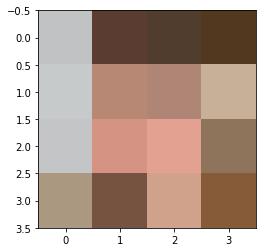

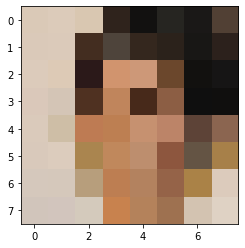

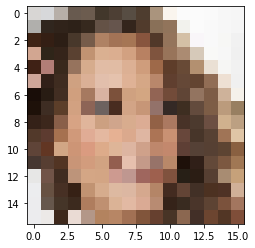

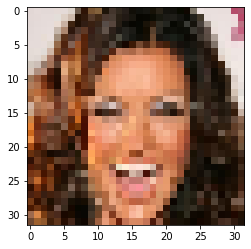

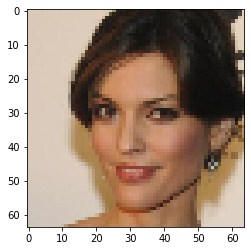

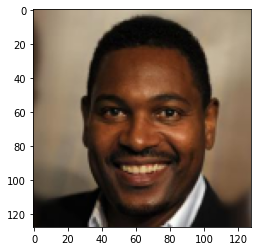

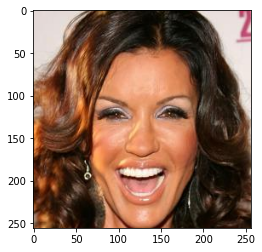

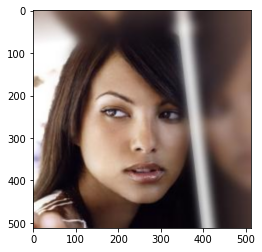

In [ ]:
for m in range(8):
  show_real(all_images, 1, (2**(2+m),2**(2+m)) )

# Models

In [ ]:
# example of progressive growing gan on celebrity faces dataset
from math import sqrt
from numpy import load
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from skimage.transform import resize
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.layers import LeakyReLU
from keras.layers import Layer
from keras.layers import Add
from keras.constraints import max_norm
from keras.initializers import RandomNormal
from keras import backend
from matplotlib import pyplot

# pixel-wise feature vector normalization layer
class PixelNormalization(Layer):
	# initialize the layer
	def __init__(self, **kwargs):
		super(PixelNormalization, self).__init__(**kwargs)

	# perform the operation
	def call(self, inputs):
		# calculate square pixel values
		values = inputs**2.0
		# calculate the mean pixel values
		mean_values = backend.mean(values, axis=-1, keepdims=True)
		# ensure the mean is not zero
		mean_values += 1.0e-8
		# calculate the sqrt of the mean squared value (L2 norm)
		l2 = backend.sqrt(mean_values)
		# normalize values by the l2 norm
		normalized = inputs / l2
		return normalized

	# define the output shape of the layer
	def compute_output_shape(self, input_shape):
		return input_shape

# mini-batch standard deviation layer
class MinibatchStdev(Layer):
	# initialize the layer
	def __init__(self, **kwargs):
		super(MinibatchStdev, self).__init__(**kwargs)

	# perform the operation
	def call(self, inputs):
		# calculate the mean value for each pixel across channels
		mean = backend.mean(inputs, axis=0, keepdims=True)
		# calculate the squared differences between pixel values and mean
		squ_diffs = backend.square(inputs - mean)
		# calculate the average of the squared differences (variance)
		mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
		# add a small value to avoid a blow-up when we calculate stdev
		mean_sq_diff += 1e-8
		# square root of the variance (stdev)
		stdev = backend.sqrt(mean_sq_diff)
		# calculate the mean standard deviation across each pixel coord
		mean_pix = backend.mean(stdev, keepdims=True)
		# scale this up to be the size of one input feature map for each sample
		shape = backend.shape(inputs)
		output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
		# concatenate with the output
		combined = backend.concatenate([inputs, output], axis=-1)
		return combined

	# define the output shape of the layer
	def compute_output_shape(self, input_shape):
		# create a copy of the input shape as a list
		input_shape = list(input_shape)
		# add one to the channel dimension (assume channels-last)
		input_shape[-1] += 1
		# convert list to a tuple
		return tuple(input_shape)

# weighted sum output
class WeightedSum(Add):
	# init with default value
  def __init__(self, alpha=0.0, **kwargs):
    super(WeightedSum, self).__init__(**kwargs)
    self.alpha = backend.variable(alpha, name='ws_alpha')

	# output a weighted sum of inputs
  def _merge_function(self, inputs):
    # only supports a weighted sum of two inputs
    assert (len(inputs) == 2)
    # ((1-a) * input1) + (a * input2)
    output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
    return output

  def get_config(self):
    return super(WeightedSum, self).get_config()

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
  wl = backend.mean(y_true * y_pred)
  if wl > 0:
    return backend.log(wl)
  else:
    return (-1 * backend.log(wl * -1))

# add a discriminator block
def add_discriminator_block(old_model, n_input_layers=3):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # weight constraint
  const = max_norm(1.0)
  # get shape of existing model
  in_shape = list(old_model.input.shape)
  # define new input shape as double the size
  input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
  in_image = Input(shape=input_shape)
  # define new input processing layer
  d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  # define new block
  d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = AveragePooling2D()(d)
  block_new = d
  # skip the input, 1x1 and activation for the old model
  for i in range(n_input_layers, len(old_model.layers)):
    d = old_model.layers[i](d)
  # define straight-through model
  model1 = Model(in_image, d)
  # compile model
  model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
  # downsample the new larger image
  downsample = AveragePooling2D()(in_image)
  # connect old input processing to downsampled new input
  block_old = old_model.layers[1](downsample)
  block_old = old_model.layers[2](block_old)
  # fade in output of old model input layer with new input
  d = WeightedSum()([block_old, block_new])
  # skip the input, 1x1 and activation for the old model
  for i in range(n_input_layers, len(old_model.layers)):
    d = old_model.layers[i](d)
  # define straight-through model
  model2 = Model(in_image, d)
  # compile model
  model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
  return [model1, model2]

# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4,4,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	model_list = list()
	# base model input
	in_image = Input(shape=input_shape)
	# conv 1x1
	d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 3x3 (output block)
	d = MinibatchStdev()(d)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 4x4
	d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# dense output layer
	d = Flatten()(d)
	out_class = Dense(1, kernel_constraint=const, activation='linear')(d)
	# define model
	model = Model(in_image, out_class)
	# compile model
	model.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_discriminator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

# add a generator block
def add_generator_block(old_model):
  # weight initialization
  init = RandomNormal(stddev=0.02)
	# weight constraint
  const = max_norm(1.0)
  # get the end of the last block
  block_end = old_model.layers[-2].output
  # upsample, and define new block
  upsampling = UpSampling2D()(block_end)
  g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
  g = PixelNormalization()(g)
  g = LeakyReLU(alpha=0.2)(g)
  g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
  g = PixelNormalization()(g)
  g = LeakyReLU(alpha=0.2)(g)
  # add new output layer
  out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const, activation='tanh')(g)
  # define model
  model1 = Model(old_model.input, out_image)
  # get the output layer from old model
  out_old = old_model.layers[-1]
  # connect the upsampling to the old output layer
  out_image2 = out_old(upsampling)
  # define new output image as the weighted sum of the old and new models
  merged = WeightedSum()([out_image2, out_image])
  # define model
  model2 = Model(old_model.input, merged)
  return [model1, model2]

# define generator models
def define_generator(latent_dim, n_blocks, in_dim=4):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	model_list = list()
	# base model latent input
	in_latent = Input(shape=(latent_dim,))
	# linear scale up to activation maps
	g  = Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
	g = Reshape((in_dim, in_dim, 128))(g)
	# conv 4x4, input block
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# conv 3x3
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# conv 1x1, output block
	out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const, activation='tanh')(g)
	# define model
	model = Model(in_latent, out_image)
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_generator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

# define composite models for training generators via discriminators
def define_composite(discriminators, generators):
	model_list = list()
	# create composite models
	for i in range(len(discriminators)):
		g_models, d_models = generators[i], discriminators[i]
		# straight-through model
		d_models[0].trainable = False
		model1 = Sequential()
		model1.add(g_models[0])
		model1.add(d_models[0])
		model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# fade-in model
		d_models[1].trainable = False
		model2 = Sequential()
		model2.add(g_models[1])
		model2.add(d_models[1])
		model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# store
		model_list.append([model1, model2])
	return model_list

# update the alpha value on each instance of WeightedSum
def update_fadein(models, step, n_steps):
	# calculate current alpha (linear from 0 to 1)
	alpha = step / float(n_steps - 1)
	# update the alpha for each model
	for model in models:
		for layer in model.layers:
			if isinstance(layer, WeightedSum):
				backend.set_value(layer.alpha, alpha)

# train a generator and discriminator
def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, size, fadein=False):
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(dataset) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs

	try:
		g_model.load_weights('pggan/g_model_'+str(size[0])+'.h5')
		d_model.load_weights('pggan/d_model_'+str(size[0])+'.h5')
	except:
		pass

	for i in range(n_steps):
		# update alpha for all WeightedSum layers when fading in new blocks
		if fadein:
			update_fadein([g_model, d_model, gan_model], i, n_steps)
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch, size)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
    
		g_model.save_weights('pggan/models/g_model_'+str(size[0])+'.h5')
		d_model.save_weights('pggan/models/d_model_'+str(size[0])+'.h5')

		#if (d_loss2) > 1e3:
		#	print('\ntotal loss = ',(d_loss2))
		#	break
		print('\r >%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss), end='')

# scale images to preferred size
def scale_dataset(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# generate samples and save as a plot and save the model
def summarize_performance(status, g_model, latent_dim, n_samples=25):
	# devise name
  gen_shape = g_model.output_shape
  name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
	# generate images
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# normalize pixel values to the range [0,1]
  X = (X - X.min()) / (X.max() - X.min())
	# plot real images
  square = int(sqrt(n_samples))
  for i in range(n_samples):
    pyplot.subplot(square, square, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i])
  pyplot.show()
	# save plot to file
  filename1 = 'pggan/results/plot_%s.png' % (name)
  pyplot.savefig(filename1)
  pyplot.close()
	# save the generator model
  filename2 = 'pggan/models/model_%s.h5' % (name)
  g_model.save(filename2)
  print('\n>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
  # fit the baseline model
  g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
  # scale dataset to appropriate size
  gen_shape = g_normal.output_shape
  # train normal or straight-through models
  train_epochs(g_normal, d_normal, gan_normal, dataset, e_norm[0], n_batch[0], gen_shape[1:-1])
  summarize_performance('tuned', g_normal, latent_dim)
  # process each level of growth
  for i in range(1, len(g_models)):
    # retrieve models for this level of growth
    [g_normal, g_fadein] = g_models[i]
    [d_normal, d_fadein] = d_models[i]
    [gan_normal, gan_fadein] = gan_models[i]
    # scale dataset to appropriate size
    gen_shape = g_normal.output_shape
    
    # train fade-in models for next level of growth
    train_epochs(g_fadein, d_fadein, gan_fadein, dataset, e_fadein[i], n_batch[i], gen_shape[1:-1], True)
    summarize_performance('faded', g_fadein, latent_dim)
    show_output(g_fadein, latent_dim, 3)

    # train normal or straight-through models
    train_epochs(g_normal, d_normal, gan_normal, dataset, e_norm[i], n_batch[i], gen_shape[1:-1])
    summarize_performance('tuned', g_normal, latent_dim)
    show_output(g_normal, latent_dim, 3)

# number of growth phases, e.g. 6 == [4, 8, 16, 32, 64, 128]
n_blocks = 6
# size of the latent space
latent_dim = 100
# define models
d_models = define_discriminator(n_blocks)
# define models
g_models = define_generator(latent_dim, n_blocks)
# define composite models
gan_models = define_composite(d_models, g_models)
# load image data
#dataset = load_real_samples(all_images, 100, )
#print('Loaded', dataset.shape)
# train model
n_batch = [16, 16, 16, 16, 16, 16, 14, 8, 3]
# 10 epochs == 500K images per training phase
n_epochs = [100, 100, 100, 100, 100, 100]

# Training


 >6200, d1=-7.308, d2=6.646 g=-6.568

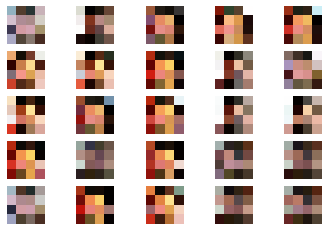


>Saved: pggan/results/plot_004x004-tuned.png and pggan/models/model_004x004-tuned.h5
 >6200, d1=18.321, d2=-18.234 g=18.330

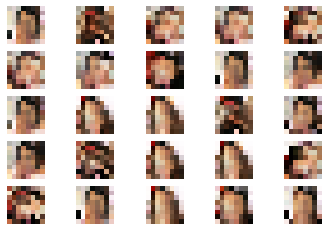


>Saved: pggan/results/plot_008x008-faded.png and pggan/models/model_008x008-faded.h5


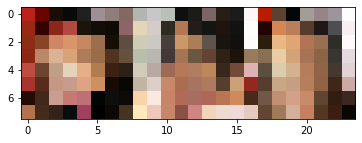

 >4581, d1=18.729, d2=-18.636 g=18.730

In [ ]:
train(g_models, d_models, gan_models, all_images[:1000], latent_dim, n_epochs, n_epochs, n_batch)